# QUANTUM BASTA

During the past years, it has spread the necessity of studying simple quantum systems so as to comprehend how more difficult quantum system behave and evolve. Many approaches has been used, whereas the Agassi's one has been considered very little.

QUANTUM BASTA project is based on the study of the Agassi Model, a nuclear physics approach aimed at the comprehension of the atomic nucleus behaviour. This quantum model is a combination of long range monopole-monopole and short range pairing interactions of N fermions.

The fermions are split into two different levels, each of degeneracy $\Omega$ (which is an even value). Using $\Omega$ we can define $j=\Omega /2$ which will be the parameter that indicates the particles' number considered in the simulation. 
Narrowing it down to the case where $N=2\Omega$, we obtain the relation $N=4*j$ . Another thing that is need to be said is that the two energy levels are identified by a different parity value, σ = -1 and σ = 1, while the magnetic quantum number takes the values m = ±1,...,± j (m = 0 is excluded). Thus, a single-particle state is labelled by (σ = ±,m).

For the work we relied on an article pubblicated on Physical Review B, titled "A digital quantum simulation of the Agassi model" by Pedro Pérez-Fernández (inserire link al paper). The first step consisted in duplicating the paper's results; then we proceeded with improving the code in order to get more reliability and efficiency. 

## Import Libraries

In [1]:
import pennylane as qml
from itertools import combinations
import networkx as nx
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

## Choose parameters

In this very first part, all the parameters and variables used are enlisted. $j$,$ \epsilon$,$g$ and $V$ are parameters that define the hamiltonian, and so, the simulation. The others are parameters used within function and loops; each of them is appropriately commented.

In [2]:
# Configure simulation below
# (these are the main parameters you might want to change, more
# specific parameters are defined when needed throughout the notebook)

# Hamiltonian parameters
j   = 1
eps = 1.0
g   = 1.0
V   = 1.0

# Parameters for the time evolution
t_max = 5.0            # Maximum evolution time
time_steps = 100       # Number of time intervals
n_trotter_steps = 10   # Number of Trotter steps
trotter_order = 1      # Trotter order
error_order = 1        # Order of the error scaling

# Automatically determine some variables based on the above
n_qubits = 4 * j
times = np.linspace(0, t_max, time_steps)

# Define the time intervals
initial_state = np.zeros(2**n_qubits)
initial_state[3] = 1.0


## Setup and Helper Functions

The following functions like "`encode_indices`" have the task of encoding the creation and annihilator operators mapping the couple parity-magnetic quantum number $(p,m)$ into a sigle index. The variable $k$ is computated using $p,m,j$ and returns exactly the new index for the operator. As every part of the code, this paragraph is thinked for generalization of j. 

The second function is the inverse process, it helps getting back the couple $(p,m)$ using only the singular operator index. It is important to check the values ​​assumed by the parameters, which is done at the beginning of the functions.

In [3]:
def encode_indices(p, m, j):
    """
    takes two different p, m and j and  encode indexes with the specified rule, it can be used for every value of j 
    """
    if p not in {1, -1}:
        raise ValueError("p must be either 1 or -1.")
    if m == 0 or not (-j <= m <= j):
        raise ValueError(f"m must be in the range +/-1, +/-2, ..., +/-j, but got m={m} and j={j}.")

    if m > 0:
        k = j - m
    else:
        k = j - m - 1 # shift by one because m can't be 0

    if p == -1:
        k += 2 * j

    return k

def decode_index(k, j):
    """
    Decode a single index k back into multi-indexes (p, m, j)
    """
    if k < 0 or k >= 4 * j:
        raise ValueError(f"k={k} is out of valid range for j={j}.")

    # Determine p based on the range of k
    p = 1 if k < 2 * j else -1

    # Adjust k for p = -1
    k_adjusted = k if p == 1 else k - 2 * j

    # Determine m
    m = j - k_adjusted if k_adjusted < j else j - (k_adjusted + 1) # inverse of the encoding line in encode_indices

    return p, m


for p in [1, -1]:
    for m in range(j, -j-1, -1):
        if m == 0: continue

        k = encode_indices(p, m, j)
        p_, m_ = decode_index(k, j)

        print("Original indices: p={}, m={}".format(p, m, j))
        print("Decoded indices:  p={}, m={}".format(p_, m_))
        print("Encoded index:    k={}".format(k))
        print()

Original indices: p=1, m=1
Decoded indices:  p=1, m=1
Encoded index:    k=0

Original indices: p=1, m=-1
Decoded indices:  p=1, m=-1
Encoded index:    k=1

Original indices: p=-1, m=1
Decoded indices:  p=-1, m=1
Encoded index:    k=2

Original indices: p=-1, m=-1
Decoded indices:  p=-1, m=-1
Encoded index:    k=3



## Hamiltonian

The most important part of this paragraph is the function `agassi_hamiltonian` which includes all the commands that defines the different terms of the hamiltonian. Since each term is a linear combination of operators of multiple indexes, we define new operators by using `qml.FermiA()` and `qml.FermiC()` (respectively for annihilators and creators), where we put as arguments the result of the encoding function. In this way, it is possible to obtain a more useful hamiltonian formula.  

Then, we calculate through for loop terms as $J^+$ and $J^-$, while with `A_dag()` and `A()` the second term. Summing up everything we have, we obtain an hamiltonian which can be used as the argument of the Pennylane function `qml.jordan_wigner`. Some things need to be said: the Jordan-Wigner trasformation is a map that, given as input a linear combination of fermionic annihilation and creation operators, return an equivalent expression of spin operators, which are the type of operators usable in quantum systems and quantum simulations. The fermionic operators obey anticommutation rules, whereas spin operators (thus Pauli operators) obey commutation rules. So it is needed a proper transformation. 

Using the formulas $c_i = \frac{1}{2} \left( \prod_{j=1}^{i-1} \sigma_j^z \right) (\sigma_i^x - i \sigma_i^y)$ and $c_i^\dagger = \frac{1}{2} \left( \prod_{j=1}^{i-1} \sigma_j^z \right) (\sigma_i^x + i \sigma_i^y)$, it is possible to change from these different types of operators
We then print the result of the computation.

### Hamiltoian Function Declaration

In [4]:
# Annihilation operator
def C(p, m, j):
    return qml.FermiA(encode_indices(p, m, j))

# Creation operator
def C_dag(p, m, j):
    return qml.FermiC(encode_indices(p, m, j))

# Agassi Hamiltonian
def agassi_hamiltonian(j, eps, g, V):
    """
    Compute the hamiltonian expression in creation and annihilation operators, evaluating each terms of the Agassi hamiltonian.
    Every term use the mapping into single index 
    """
    # J0 term
    J0 = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J0 += C_dag(1, m, j) * C(1, m, j) - C_dag(-1, m, j) * C(-1, m, j)
    J0 *= 0.5

    # J+ and J- term
    J_plus = 0
    J_minus = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J_plus  += C_dag(1, m, j) * C(-1, m, j)
        J_minus += C_dag(-1, m, j) * C(1, m, j)

    # A_i terms

    def A_dag(p, j):
        res = 0
        """ 
        unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        """
        for m in range(0, j+1):
            if m == 0: continue
            res += C_dag(p, m, j) * C_dag(p, -m, j)
        return res

    def A(p, j):
        res = 0
        """
        unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        """
        for m in range(0, j+1):
            if m == 0: continue
            res += C(p, -m, j) * C(p, m, j)
        return res

    A_terms = 0
    for p in [-1, 1]:
        for p_ in [-1, 1]:
            A_terms += A_dag(p, j) * A(p_, j)


    # Hamiltonian
    H = eps * J0 - g * A_terms - V/2 * (J_plus * J_plus + J_minus * J_minus)

    return H


### Get Hamiltonian from Specified Parameters

We can get the second quantization hamiltonian by running the following

In [5]:
H_sec = agassi_hamiltonian(j, eps, g, V)
print("Second quantization Hamiltonian:")
print(H_sec)

Second quantization Hamiltonian:
-1.0 * a⁺(2) a⁺(3) a(3) a(2)
+ -0.0 * a⁺(2) a⁺(3)
+ -0.0 * a(3) a(2)
+ 0.0 * I
+ -1.0 * a⁺(2) a⁺(3) a(1) a(0)
+ -0.0 * a(1) a(0)
+ -1.0 * a⁺(0) a⁺(1) a(3) a(2)
+ -0.0 * a⁺(0) a⁺(1)
+ -1.0 * a⁺(0) a⁺(1) a(1) a(0)
+ 0.5 * a⁺(0) a(0)
+ -0.5 * a⁺(2) a(2)
+ 0.5 * a⁺(1) a(1)
+ -0.5 * a⁺(3) a(3)
+ -0.5 * a⁺(0) a(2) a⁺(0) a(2)
+ 0.0 * a⁺(0) a(2)
+ -0.5 * a⁺(0) a(2) a⁺(1) a(3)
+ 0.0 * a⁺(1) a(3)
+ -0.5 * a⁺(1) a(3) a⁺(0) a(2)
+ -0.5 * a⁺(1) a(3) a⁺(1) a(3)
+ -0.5 * a⁺(2) a(0) a⁺(2) a(0)
+ 0.0 * a⁺(2) a(0)
+ -0.5 * a⁺(2) a(0) a⁺(3) a(1)
+ 0.0 * a⁺(3) a(1)
+ -0.5 * a⁺(3) a(1) a⁺(2) a(0)
+ -0.5 * a⁺(3) a(1) a⁺(3) a(1)


And the corresponding hamiltonian in terms of pauli sentences 

In [6]:
H_ps = qml.jordan_wigner(H_sec, ps=True)
print("Jordan-Wigner Hamiltonian:")
print(H_ps)

Jordan-Wigner Hamiltonian:
(-0.5+0j) * I
+ (0.5+0j) * Z(2)
+ (0.5+0j) * Z(3)
+ (-0.25+0j) * Z(2) @ Z(3)
+ (-0.25+0j) * Y(2) @ X(3) @ Y(0) @ X(1)
+ (-0.25+0j) * Y(2) @ X(3) @ X(0) @ Y(1)
+ (0.25+0j) * Y(2) @ Y(3) @ X(0) @ X(1)
+ (-0.25+0j) * Y(2) @ Y(3) @ Y(0) @ Y(1)
+ (-0.25+0j) * X(2) @ X(3) @ X(0) @ X(1)
+ (0.25+0j) * X(2) @ X(3) @ Y(0) @ Y(1)
+ (-0.25+0j) * X(2) @ Y(3) @ Y(0) @ X(1)
+ (-0.25+0j) * X(2) @ Y(3) @ X(0) @ Y(1)
+ (-0.25+0j) * Z(0) @ Z(1)


## Determine hamiltonian components for trotterization

#### Helper Functions for Plotting Cliques  

In [7]:
def draw_cliquet_decomposition(G_base, cliques):

    import matplotlib.pyplot as plt
    import numpy as np

    def generate_vibrant_colors(n_colors):
        """
        Generate a list of 'n_colors' distinct, vibrant colors while avoiding gray-like colors.
        """
        cmap = plt.cm.get_cmap("hsv", n_colors * 2)  # Use HSV colormap for high-saturation colors
        colors = [cmap(i) for i in range(n_colors * 2)]  # Get extra colors to filter

        # Keep only highly saturated colors (skip grays)
        vibrant_colors = [color for color in colors if np.mean(color[:3]) < 0.75]  # Avoid desaturated tones
        return vibrant_colors[:n_colors]  # Return only the needed number of colors

    # Example: Generate 15 vibrant colors with no grays
    num_cliques = len(cliques)  # Arbitrary dimension
    colors = generate_vibrant_colors(num_cliques)


    # Plot the original graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G_base)

    # Draw the original graph in gray (background)
    nx.draw(G_base, pos, with_labels=True, node_color="lightgray", edge_color="gray", node_size=50, font_size=10, alpha=0.2)

    # Draw each clique with a different color
    for i, clique in enumerate(cliques):
        nx.draw_networkx_nodes(G_base, pos, nodelist=clique, node_color=[colors[i]], node_size=200, alpha=0.5)
        nx.draw_networkx_edges(G_base, pos, edgelist=[(u, v) for u in clique for v in clique if G_base.has_edge(u, v)], edge_color=[colors[i]], width=2, alpha=0.5)

    plt.title("Original Graph with Highlighted Cliques")
    plt.show()

#### Helper Function for Manipulating Pennylane Hamiltonian Terms

If Pennylane finds pauli sentences that contain null coefficients related to some pauli words, it erases automatically those terms. This can create some problems if we want to compute calculation between expressions that have different dimensions, because the code doesn't recognise the missing parts. That's why we introduce manually all the terms previously removed from the hamiltonian, exploiting `add_implicit_terms`.

In [8]:
from copy import deepcopy

def add_implicit_terms(H1_raw, n_qubits):
    """
    a copy of the hamiltonian given as an input is made, then it is done a check of the pauli words contained within the hamiltonian expression
    and if some specific pauli words have been removed by Pennlyane they're reintroduced pinned to a coefficient equals to 0.0.
    """
    H_new = deepcopy(H1_raw)
    for i in range(0, n_qubits):
        w = qml.pauli.PauliWord({i:"Z"})
        if w not in H1_raw:
            H_new[w] = 0.0
    return H_new

#### Clique Handling Functions

In [9]:
def get_hamiltonian_graph(H):
    """
    We compute the hamiltonian graph, evaluating every commutator and adding, if necessary, links between terms
    """

    H_list = list(zip(H_ps.keys(), H.values()))
    G = nx.Graph()
    G.add_nodes_from(H_list)

    # Compute commutators and add edges if they commute
    for i in range(len(H_list)):
        for k in range(i + 1, len(H_list)):
            a = H_list[i][0]    #with the index[0] it takes only the first element aka the operator and it calculates the commutator
            b = H_list[k][0]    #same as above
            if len(a.commutator(b)) == 0:  # Check commutation
                G.add_edge(H_list[i], H_list[k])
    return G


def get_clique_partitioning(G, cliques, verbose=False):

    iteration = 1
    while G.number_of_nodes() > 0:
        iter_node = nx.find_cliques(G)  #automatically finds the clique
        try:
            clique = next(iter_node) #try to find another clique, if there is one advances and finds it
        except StopIteration:
            break  # If no more cliques, exit loop

        if verbose:
            print(f"Iteration {iteration}: Removing clique {clique}")

        # Remove clique from graph
        cliques.append(clique)
        G.remove_nodes_from(clique)
        iteration += 1

    if verbose:
        print("Final graph (should be empty):", G.nodes())

    return cliques


def construct_hamiltonian_terms_from_cliques(cliques):
    """
    This function reconstructs the hamiltonian terms analyzing for each clique each term contained inside of the clique and
    adding it to the array H_terms, specifying the coefficient associated
    """
    
    H_terms = []
    for i in range(len(cliques)):
        H_term = qml.pauli.PauliSentence()
        for k in range(len(cliques[i])):
            H_term[cliques[i][k][0]] = cliques[i][k][1]
        H_terms.append(H_term)
    return H_terms

In [10]:
# get best clique computing by computing trotter error
# At the moment this funciton finds different cliques partition starting from different initial maximal cliques

def get_best_clique_partitioning(G_base, n_qubits, error_order=1, verbose=False):
    best_cliques = None
    best_err = np.inf
    order=list(range(0,n_qubits))

    first_cliques = list(nx.find_cliques(G_base)) #list of all cliques

    def commutator_list(list1, list2):
        """
        create a list containing every commutator between objects belonging to the two input lists
        """

        commutators = []
        for i in range(len(list1)):
            for j in range(len(list2)):
                comm = qml.commutator(list1[i], list2[j], pauli=True)
                commutators.append(comm)
        return commutators

    for first_clique in first_cliques: # first_clique is a single clique contained in the list first_cliques

        G = G_base.copy()
        G.remove_nodes_from(first_clique)   # once it has been removed the i-th clique considered by the loop, 
                                            # the element remaining are manipulated so as to find a new version of the others clique
        cliques = [first_clique]
        cliques = get_clique_partitioning(G, cliques, verbose=verbose)
        commutators = []

        H_terms = construct_hamiltonian_terms_from_cliques(cliques)

        err = 0 
        for i in range(len(H_terms)):
            for j in range(i+1, len(H_terms)):
                first_commutator =qml.commutator(H_terms[i], H_terms[j], pauli=True)
                commutators.append(first_commutator)

        for p in range(1,error_order):  # this is used if we want to consider higher order errors, so it is reiterated the computation with commutators and H_terms
            commutators=commutator_list(H_terms, commutators)

        for comm in commutators:
            if error_order%2 == 0:
                err += np.max(np.abs(np.linalg.eigvalsh(qml.matrix(comm, wire_order=order))))
            else:
                err += np.max(np.abs(np.linalg.eigvalsh(-1j * qml.matrix(comm, wire_order=order))))

        if err < best_err:
            best_err = err
            best_cliques = cliques

    if verbose:
        print("Best error:", best_err)
    
    return best_cliques

### Get Best Clique Decomposition

In [11]:
G = get_hamiltonian_graph(H_ps)
G_base = G.copy() # Save a copy of the original graph for visualization

cliques = get_best_clique_partitioning(G, n_qubits, error_order=error_order, verbose=False)
H_terms = construct_hamiltonian_terms_from_cliques(cliques)
print("number of terms in hamiltonian:", len(H_terms))

number of terms in hamiltonian: 2


`draw_cliquet_decomposition` is used to draw the clique graph. The necessity of adding this function was due to the fact that by default Pennylane draw graph with only shades of grey. In order to have a more comprehensible diagram, an appropriate number of different colors is generated by `generate_vibrant_colors`. Then, the graph is drawn. 

/var/folders/_h/zshrjsxs42s1yscqytrdy2q00000gn/T/ipykernel_32102/2006917434.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hsv", n_colors * 2)  # Use HSV colormap for high-saturation colors


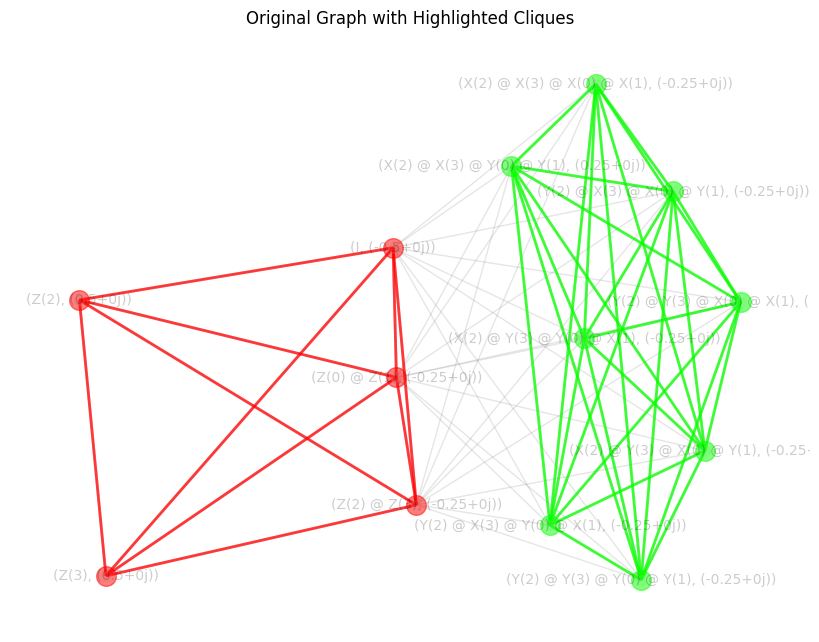

In [12]:
draw_cliquet_decomposition(G_base, cliques)

### Check Commutators

In [13]:
# Check that terms within a given clique commute
def test_internal_commutativity(H_term):

    all_commute = True
    split_sentences = {}
    for pauli_word, value in H_term.items():
        if pauli_word not in split_sentences:
            split_sentences[pauli_word] = qml.pauli.PauliSentence()

    # Iterate over all pairs of PauliSentences from split_sentences2 and test commutativity
    for (key1, ps1), (key2, ps2) in combinations(split_sentences.items(), 2):
        comm = qml.commutator(key1,key2, pauli=True)

        # Check if they commute
        if not np.allclose(comm.operation().matrix(), 0):
            all_commute = False

    return all_commute

# Check commutativity amongst all combinations of a given list of temrms
def test_commutativity_among_terms(H_terms, verbose=False):
    """Check commutativity of all pairs in the given list of Pauli words."""
    num_terms = len(H_terms)

    for i in range(num_terms):
        for j in range(i + 1, num_terms):  # Check only unique pairs (i, j)
            ps1 = H_terms[i]
            ps2 = H_terms[j]

            # Compute the commutator using PennyLane
            comm = ps1.commutator(ps2)

            # Check if the commutator is empty (i.e., they commute)
            is_commuting = len(comm) == 0
            print(f"Term {i} and term {j} commute: ", is_commuting)
            if verbose:
                print(f"Term {i}: {ps1}")
                print(f"Term {j}: {ps2}")
                print(f"Commutator: {comm}")

In [14]:
print("Testing commutativity within each clique:")
for i in range(len(H_terms)):
    print("Terms within the", str(i) + "-th clique commute: ", test_internal_commutativity(H_terms[i]))

print("\nTesting commutativity amongst different hamiltonian terms:")
test_commutativity_among_terms(H_terms, verbose=False)


Testing commutativity within each clique:
Terms within the 0-th clique commute:  True
Terms within the 1-th clique commute:  True

Testing commutativity amongst different hamiltonian terms:
Term 0 and term 1 commute:  False


## Time Evolution

### Plotting Helper Functions

In [15]:
def plot_results(x, y, title="Results", label="Overlap", xlabel="Time", ylabel="Overlap", ylim=[0, 1.2]):
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

def plot_comparison(x, y1, y2, title="Results", label1="Data 1", label2="Data 2", xlabel="Time", ylabel="Overlap", ylim=[0, 1.2],
                    alpha=0.7, linestyle1="-", linestyle2="--"):
    plt.figure(figsize=(8, 6))
    plt.plot(x, y1, label=label1, alpha=alpha, linestyle=linestyle1)
    plt.plot(x, y2, label=label2, alpha=alpha, linestyle=linestyle2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

### Helper Functions

In [16]:
# get matrix form of a single pauli sentence
def get_matrix_from_ps(ps):
    order = list(range(n_qubits))
    for i in range(0,n_qubits):
        order[i]=i
    mat = qml.matrix(H_ps, wire_order=order)
    return mat

# get matrix forsm of a list of pauli sentences
# this function makes sure that the size of the matrices is correct
# by automatically adding implicit terms removed by Pennylane
def get_matrix_from_multiple_ps(ps_list, n_qubits):
    ps_list_implicit = []
    for term in ps_list:
        ps_list_implicit.append(add_implicit_terms(term, n_qubits))

    mat_list = []
    for term in ps_list_implicit:
        order = list(range(n_qubits))
        for i in range(0,n_qubits):
            order[i]=i
        mat_list.append(qml.matrix(term, wire_order=order))

    return mat_list

### Exact and Trotterized Evolution Function Declaration

In [17]:
# exact time evolution
def exact_evo(H, initial_state, t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t))
    evolved_state = U @ initial_state
    return evolved_state

# correlation function
def trotter_evo(H_terms_mat, initial_state, t, n, trotter_order=1):

    if trotter_order == 1:
        # U = np.identity(H.shape[0])
        U = np.identity(H_terms_mat[0].shape[0]) # CHECK CHE NON CAMBIA NULLA
        for _ in range(0, n):
            for term in H_terms_mat:
                U = U @ expm(-1j * term * (t/n))

        evolved_state = U @ initial_state
        return evolved_state

    else:
        
        if trotter_order%2 == 1: raise ValueError("Trotter order must be even or 1.")

        # recursive function to compute the trotter block
        def trotter_block(k, t, n):

            # U = np.identity(H.shape[0])
            U = np.identity(H_terms_mat[0].shape[0])
            if k == 1:  # second order (k=trotter_order/2 with trotter_order=2)
                for i in range(len(H_terms_mat)-1):
                    term = H_terms_mat[i]
                    U = U @ expm(-0.5j * term * (t/n))
                U = U @ expm(-1j * H_terms_mat[-1] * (t/n))

                for i in range(len((H_terms_mat))-2, -1, -1):
                    term = H_terms_mat[i]
                    U = U @ expm(-0.5j * term * (t/n))

                return U

            else:   # 2k-th order of the suzuki-trotter
                u_k = 1/(4-4**(1/(2*k-1)))
                a = trotter_block(k-1, u_k * t, n)
                b = a @ a
                c = trotter_block(k-1, (1 - 4*u_k) * t, n)
                U = b @ c @ b
                return U

        # U = np.identity(H.shape[0])
        U = np.identity(H_terms_mat[0].shape[0])
        block = trotter_block(trotter_order/2, t, n)
        for _ in range(n):
            U = U @ block

        return U @ initial_state

In [18]:
#compute correlation function
def correlation_function(evo, n_qubits, i=0, k=1):
    """calculation of the correlation function for Z-Pauli operators"""

    Zi_raw = qml.pauli.PauliWord({i:"Z"})
    Zk_raw = qml.pauli.PauliWord({k:"Z"})
    psi = qml.pauli.PauliSentence()
    psi[Zi_raw] = 1.0
    psk = qml.pauli.PauliSentence()
    psk[Zk_raw] = 1.0

    order = list(range(n_qubits))
    for s in range(0,n_qubits):
        order[s] = s

    Zi = qml.matrix(add_implicit_terms(psi, n_qubits), wire_order=order)
    Zk = qml.matrix(add_implicit_terms(psk, n_qubits), wire_order=order)

    sigma_ik = np.vdot(evo, Zi @ Zk @ evo) - np.vdot(evo ,Zi @ evo) * np.vdot(evo, Zk @ evo)
    sigma_ik = np.real(sigma_ik)
    return sigma_ik

In [19]:
def run_simulation_exact(H, initial_state, times):
    states = []
    for t in times:
        state = exact_evo(H, initial_state, t)
        states.append(state)
    return states

def run_simulation_trotter(H_terms_mat, initial_state, times, n_trotter_steps, trotter_order):
    states = []
    for t in times:
        state = trotter_evo(H_terms_mat, initial_state, t, n_trotter_steps, trotter_order)
        states.append(state)
    return states

def run_simulation_trotter_variable_trotter_steps(H_terms_mat, initial_state, time, trotter_steps, trotter_order):
    states = []
    for n in trotter_steps:
        state = trotter_evo(H_terms_mat, initial_state, time, n, trotter_order)
        states.append(state)
    return states

def get_correlations_from_states(states, n_qubits, i=0, k=1):
    correlations = []
    for state in states:
        correlation = correlation_function(state, n_qubits, i=i, k=k)
        correlations.append(correlation)
    return correlations

def get_overlap_from_states(states, target_state):
    overlaps = []
    for state in states:
        overlap = np.abs(np.vdot(state, target_state))**2
        overlaps.append(overlap)
    return overlaps

def get_overlap_between_states(states1, states2):
    overlaps = []
    for state1, state2 in zip(states1, states2):
        overlap = np.abs(np.vdot(state1, state2))**2
        overlaps.append(overlap)
    return overlaps

### Compute Evolution

In [20]:
# Compute exact time evolution
H_mat = get_matrix_from_ps(H_ps) 
exact_states = run_simulation_exact(H_mat, initial_state, times)
exact_overlaps = get_overlap_from_states(exact_states, initial_state)
exact_correlations = get_correlations_from_states(exact_states, n_qubits, i=0, k=1)

# Compute trotterized time evolution
H_mat_terms = get_matrix_from_multiple_ps(H_terms, n_qubits) 
trotter_states = run_simulation_trotter(H_mat_terms, initial_state, times, n_trotter_steps, trotter_order)
trotter_overlaps = get_overlap_from_states(trotter_states, initial_state)
trotter_correlations = get_correlations_from_states(trotter_states, n_qubits, i=0, k=1)

# Compare the results at each time step
exact_trotter_ovelaps = get_overlap_between_states(exact_states, trotter_states)

### Plot the results

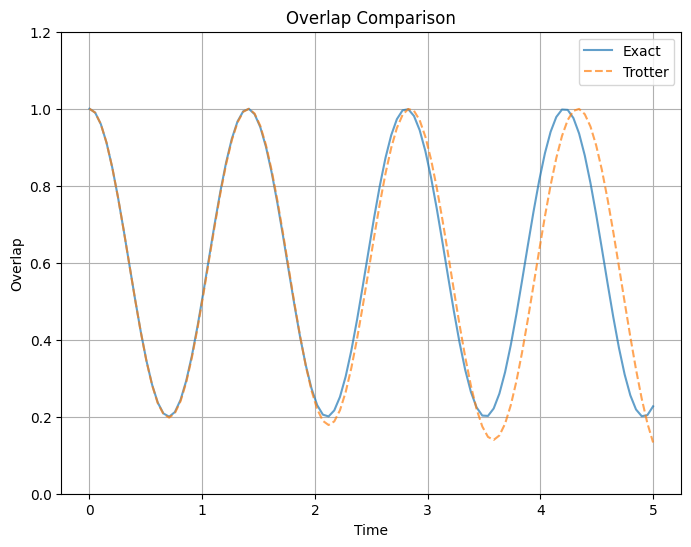

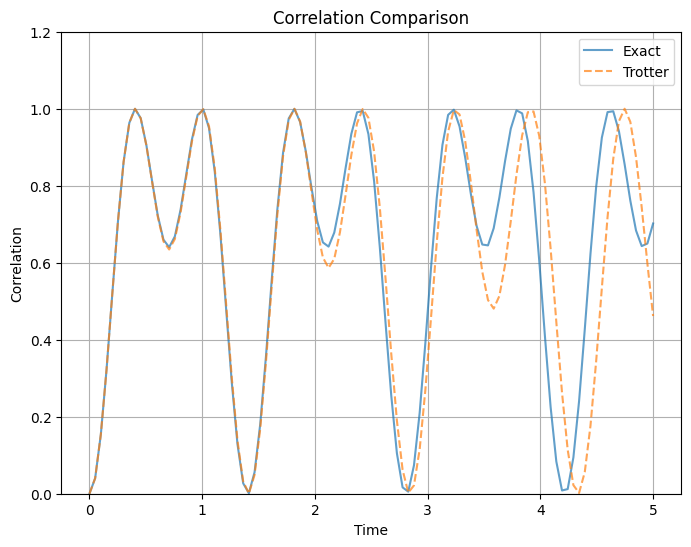

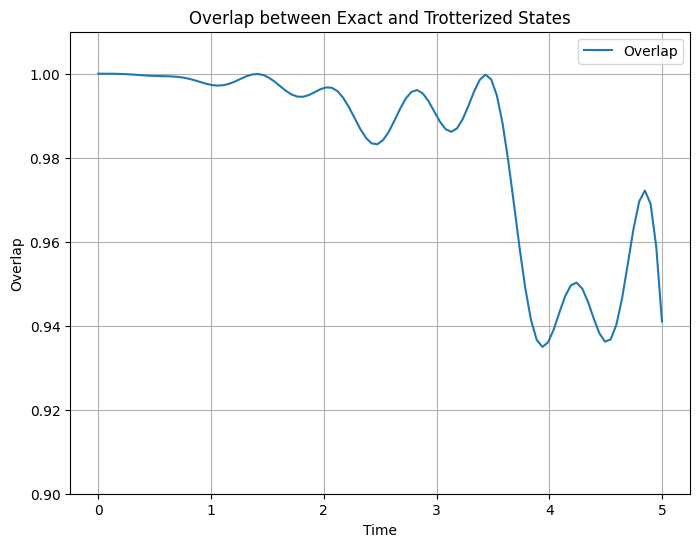

In [21]:
# Uncomment the following lines to plot the results singularly instead

# Plot the results for the exact time evolution
# plot_results(times, exact_overlaps, title="Exact Overlap")
# plot_results(times, exact_correlations, title="Exact Correlation", label="Correlation", ylabel="Correlation")

# Plot the results for the trotterized time evolution
# plot_results(times, trotter_overlaps, title="Trotter Overlap")
# plot_results(times, trotter_correlations, title="Trotter Correlation", label="Correlation", ylabel="Correlation")


# Uncomment the following lines to plot the results together

# Plot the comparison between exact and trotterized time evolution
plot_comparison(times, exact_overlaps, trotter_overlaps,
                title="Overlap Comparison",
                label1="Exact",
                label2="Trotter",
                ylabel="Overlap",
                ylim=[0, 1.2])

# Plot the comparison of correlations obtained from exact and trotterized time evolution
plot_comparison(times, exact_correlations, trotter_correlations,
                title="Correlation Comparison",
                label1="Exact", 
                label2="Trotter",
                ylabel="Correlation")

# Plot the scalar product of the states obtained from exact and trotterized time evolution
plot_results(times, exact_trotter_ovelaps,
             title="Overlap between Exact and Trotterized States",
             label="Overlap",
             ylabel="Overlap",
             ylim=[0.9, 1.01])

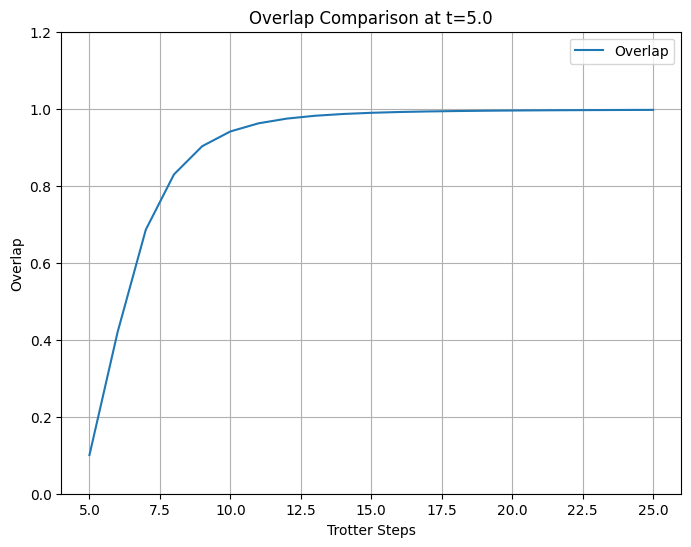

In [22]:
t_comparison = 5.0     # time at which the comparison is made
min_trotter_step = 5   # minimum number of trotter steps
max_trotter_step = 25  # maximum number of trotter steps
trotter_steps = np.arange(min_trotter_step, max_trotter_step + 1)
trotter_states_variable_trotter_steps = run_simulation_trotter_variable_trotter_steps(H_mat_terms, initial_state, t_comparison, trotter_steps, trotter_order)
exact_state_at_t = exact_evo(H_mat, initial_state, t_max)
overlaps_variable_trotter_steps = get_overlap_from_states(trotter_states_variable_trotter_steps, exact_state_at_t)

plot_results(trotter_steps, overlaps_variable_trotter_steps,
             title="Overlap Comparison at t={}".format(t_comparison),
             label="Overlap",
             xlabel="Trotter Steps",
             ylabel="Overlap")
